# **Airline Passenger Satisfaction - XAI techniques**


## **Group XXX**
- Athos Freitas - up202108792
- Félix Martins - up202108837
- Luís Du - up202105385

## **Table of contents**

- [Task 1. Dataset and Learning Task](#task-1-dataset-and-learning-task)
  - [1.1. About this dataset](#11-about-this-dataset)
  - [1.2. Data Preprocessing](#12-data-preprocessing)
  - [1.3. Principal Component Analysis (PCA)](#13-principal-component-analysis-pca)
  - [1.4. t-distributed Stochastic Neighbor Embedding (TSNE)](#14-t-distributed-stochastic-neighbor-embedding)
  - [1.5. Correlation Matrix](#15-correlation-matrix)
  
- [Task 2. In-Modeling Explanations](#task-2-in-modeling-explanations)
  - [2.1. Glass Box Model - Decision Tree with depth 3](#21-glass-box-model---decision-tree-with-depth-3)
  - [2.2. Decision Tree Visualization](#22-decision-tree-visualization)
  - [2.3. Feature importance](#23-feature-importance)
  
- [Task 3. Post-Modeling Explanations](#task-3-post-modeling-explanations)
  - [Black box model - XGBoost](#black-box-model---xgboost)
  - [Fine tuning model](#fine-tuning-model)

## Setup

In [168]:
%pip install -qU numpy pandas matplotlib seaborn scikit-learn==1.5.2 xgboost alibi shap

Note: you may need to restart the kernel to use updated packages.


## **Task 1: Dataset and Learning Task**

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin

In [170]:
df = pd.read_csv('airline_passenger_satisfaction.csv')

In [171]:
# check class imbalance
df['Satisfaction'].value_counts()

Satisfaction
Neutral or Dissatisfied    73452
Satisfied                  56428
Name: count, dtype: int64

### **1.1. About this dataset**

In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   ID                                      129880 non-null  int64  
 1   Gender                                  129880 non-null  object 
 2   Age                                     129880 non-null  int64  
 3   Customer Type                           129880 non-null  object 
 4   Type of Travel                          129880 non-null  object 
 5   Class                                   129880 non-null  object 
 6   Flight Distance                         129880 non-null  int64  
 7   Departure Delay                         129880 non-null  int64  
 8   Arrival Delay                           129487 non-null  float64
 9   Departure and Arrival Time Convenience  129880 non-null  int64  
 10  Ease of Online Booking                  1298

In [173]:
df['Satisfaction'].value_counts()

Satisfaction
Neutral or Dissatisfied    73452
Satisfied                  56428
Name: count, dtype: int64

### **1.2. Data preprocessing**

In [174]:
class RemoveHighlyCorrelated(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.8):
        self.threshold = threshold
        self.features_to_remove = []

    def transform(self, X, y=None):
        for feature in self.features_to_remove:
            X.drop(feature, axis=1, inplace=True)
        return X

    def fit(self, X, y=None):
        for pair in self.get_highly_correlated_pairs(X):
            feature = self.get_lowest_variance_feature(pair, X)
            self.features_to_remove.append(feature)
        return self
    
    def get_highly_correlated_pairs(self, X):
        pairs_value = X.corr().unstack()
        high_corr_pairs = pairs_value[(pairs_value > self.threshold) & (pairs_value < 1)].sort_values(ascending=False)
        return self.remove_duplicates(high_corr_pairs)
    
    def remove_duplicates(self, pairs):
        unique_pairs = set()
        filtered_pairs = {}
        for index, value in pairs.items():
            pair = tuple(sorted(index))
            if pair not in unique_pairs:
                unique_pairs.add(pair)
                filtered_pairs[index] = value
        return filtered_pairs.keys()
    
    def get_lowest_variance_feature(self, pair, X):
        feature1, feature2 = pair
        return feature1 if X[feature1].var() < X[feature2].var() else feature2
    
    def get_features_to_remove(self):
        return self.features_to_remove

In [175]:
df.drop("ID", axis=1, inplace=True)
df.dropna(axis=0, how='any', subset=None, inplace=True)
df['Satisfaction'] = df['Satisfaction'].map({'Neutral or Dissatisfied': 0, 'Satisfied': 1})

In [176]:
categorical_columns = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
numerical_columns = df.select_dtypes(include=['int64', 'float64']).drop("Satisfaction", axis=1).columns.tolist()

numerical_transformer = Pipeline(
    steps=[
        ('remove_corr', RemoveHighlyCorrelated()),
        ('scaler', StandardScaler()),   
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ],
    remainder='passthrough'
)

X = df.drop('Satisfaction', axis=1)
y = df['Satisfaction']

### **1.3. Principal Component Analysis (PCA)**

In [177]:
X_processed = preprocessor.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

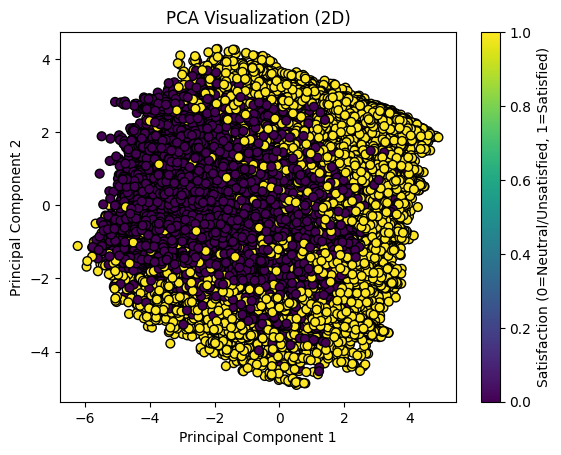

In [178]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y,
            cmap='viridis', edgecolor='k', s=40)
plt.title("PCA Visualization (2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Satisfaction (0=Neutral/Unsatisfied, 1=Satisfied)')
plt.show()

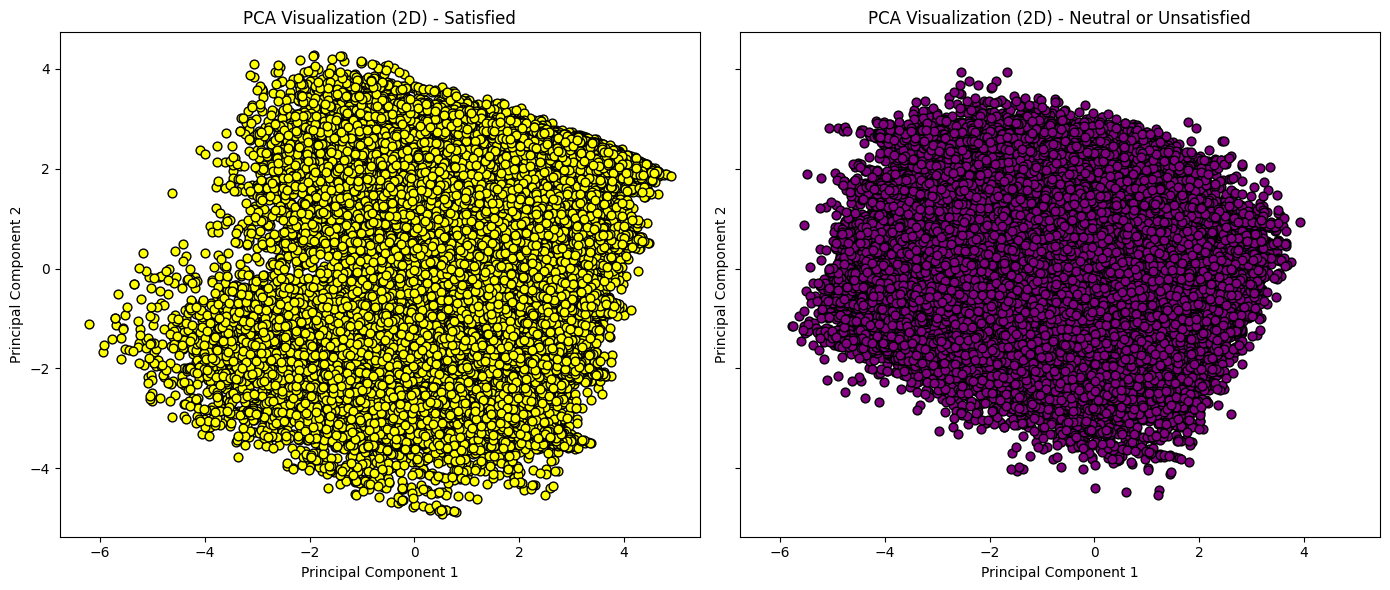

In [179]:
X_pca_sat = X_pca[df['Satisfaction'] == 1]
X_pca_unsat = X_pca[df['Satisfaction'] == 0]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

axes[0].scatter(X_pca_sat[:, 0], X_pca_sat[:, 1], c = "yellow",
             edgecolor='k', s=40)
axes[0].set_title("PCA Visualization (2D) - Satisfied")
axes[0].set_xlabel("Principal Component 1")
axes[0].set_ylabel("Principal Component 2")

axes[1].scatter(X_pca_unsat[:, 0], X_pca_unsat[:, 1], c = 'purple',
            edgecolor='k', s=40)
axes[1].set_title("PCA Visualization (2D) - Neutral or Unsatisfied")
axes[1].set_xlabel("Principal Component 1")
axes[1].set_ylabel("Principal Component 2")

plt.tight_layout()
plt.show()

### **1.4. t-distributed Stochastic Neighbor Embedding (TSNE)**

In [180]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=1000, n_iter=1000, n_jobs=-1)

sample_df, _ = train_test_split(df, stratify=df["Satisfaction"], test_size=0.9, random_state=42)
sample_X = sample_df.drop("Satisfaction", axis=1)

sample_X_processed = preprocessor.transform(sample_X)

X_tsne = tsne.fit_transform(sample_X_processed)

/home/minipoloalex/Documents/XAI-techniques/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


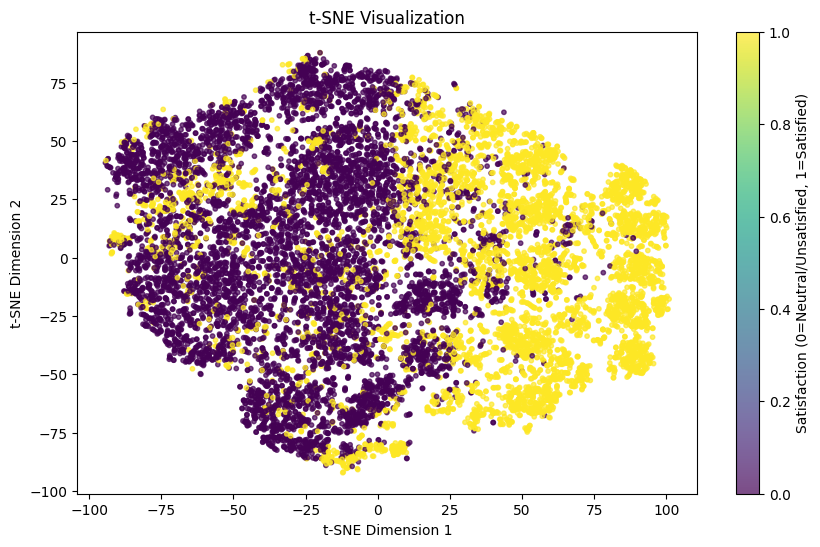

In [181]:
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=sample_df['Satisfaction'], cmap='viridis', s=10, alpha=0.7)
plt.colorbar(label='Satisfaction (0=Neutral/Unsatisfied, 1=Satisfied)')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

### **1.5. Correlation Matrix**

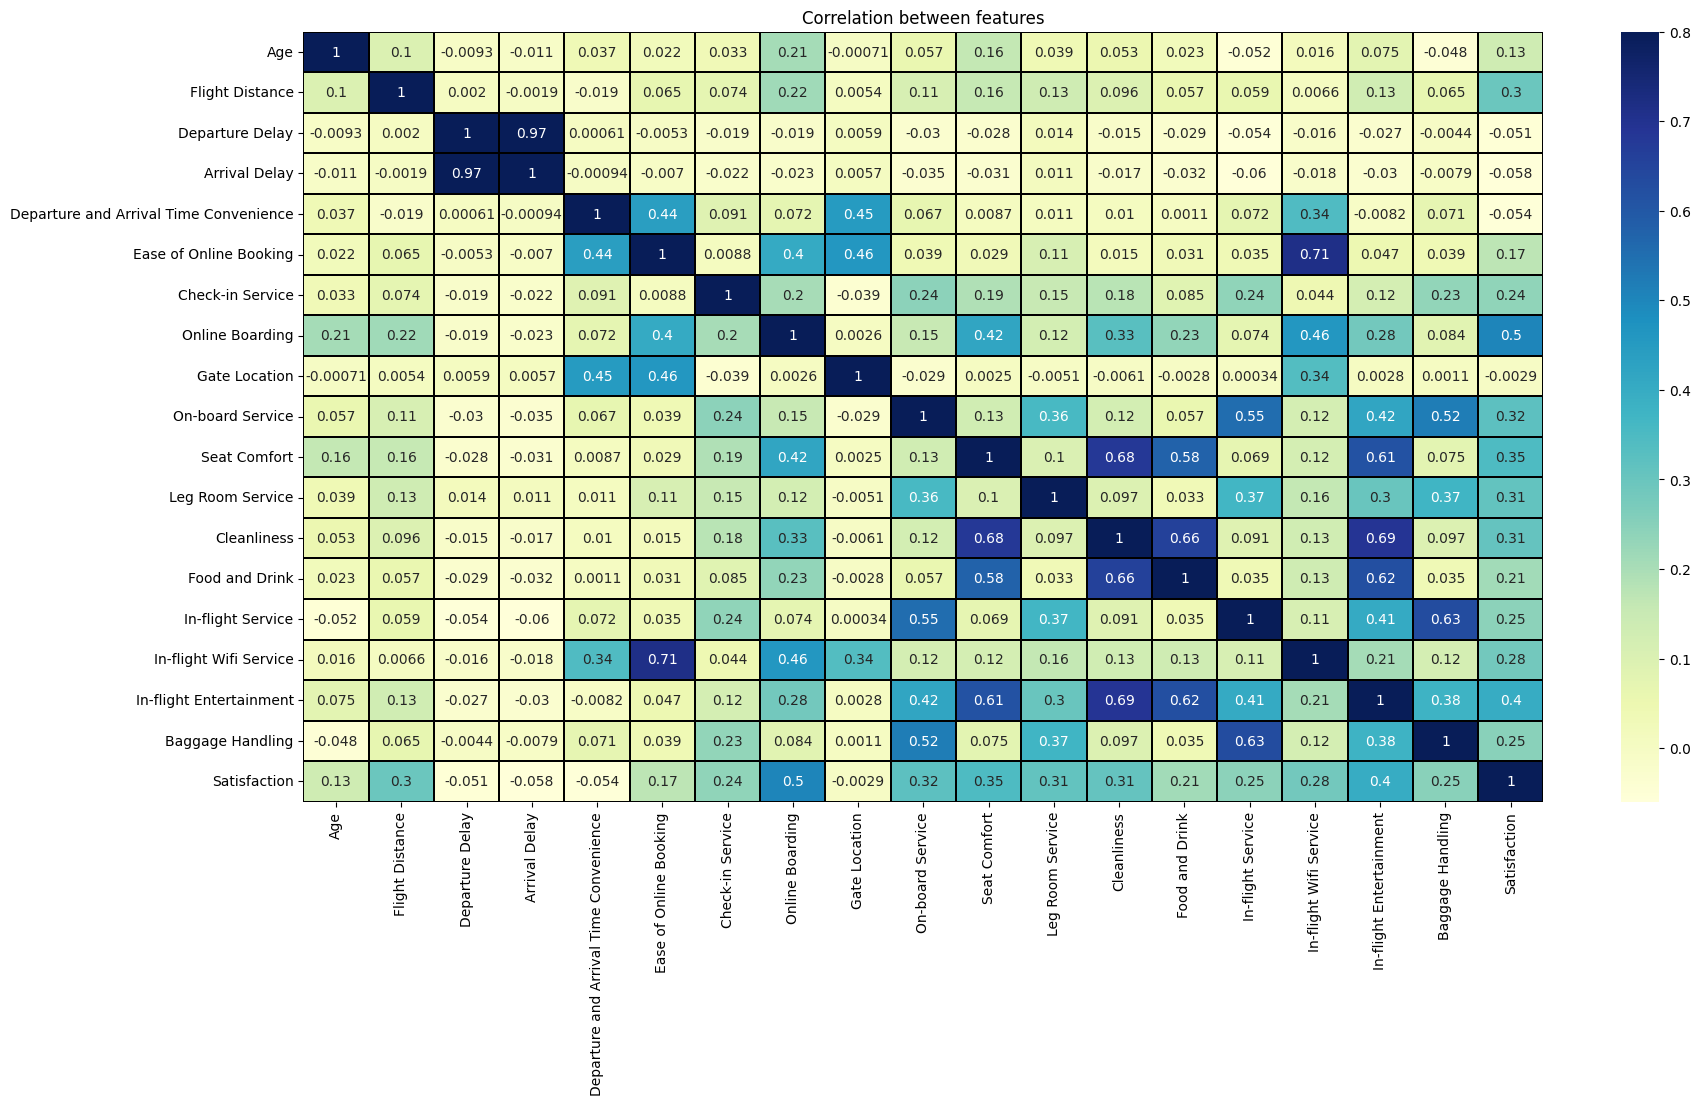

In [182]:
correlation_matrix = df.select_dtypes(include=['int64', 'float64']).corr()

plt.figure(figsize=(20,10))
sns.heatmap(correlation_matrix,  vmax=0.8, linewidth=0.01, annot = True, cmap='YlGnBu', linecolor ='black')
plt.title('Correlation between features')
plt.show()

---

## **Task 2: In-Modeling Explanations**

### **2.1. Glass Box Model - Decision Tree with depth 3**

In [183]:
class StoreDataFrame(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.data = None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.data = X
        return X
    
    def get_processed_df(self, preprocessor):
        removed_numerical_features = preprocessor.named_transformers_['num'].named_steps['remove_corr'].get_features_to_remove()
        filtered_numerical_columns = [feature for feature in numerical_columns if feature not in removed_numerical_features]
        feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns).tolist() + filtered_numerical_columns     
        return pd.DataFrame(self.data, columns=feature_names)

In [184]:
tree_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_columns),   
        ('num', Pipeline(steps=[('remove_corr', RemoveHighlyCorrelated())]), numerical_columns)
    ],
    remainder='passthrough'
)

store_processed_df = StoreDataFrame()
tree_clf = DecisionTreeClassifier(random_state=42, max_depth=3)

model = Pipeline(steps=[
    ('preprocessor', tree_preprocessor),
    ('store_df', store_processed_df),
    ('classifier', tree_clf)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Gender', 'Customer Type',
                                                   'Type of Travel', 'Class']),
                                                 ('num',
                                                  Pipeline(steps=[('remove_corr',
                                                                   RemoveHighlyCorrelated())]),
                                                  ['Age', 'Flight Distance',
                                                   'Departure Delay',
                                                   'Arrival Delay',
                                                   'Departure and Arrival Time '
                                                   'Convenience',
                                                   'Ease of Online Booking',
                                                   'Check-in Service',
                                                   'Online Boarding',
                                                   'Gate Location',
                                                   'On-board Service',
                                                   'Seat Comfort',
                                                   'Leg Room Service',
                                                   'Cleanliness',
                                                   'Food and Drink',
                                                   'In-flight Service',
                                                   'In-flight Wifi Service',
                                                   'In-flight Entertainment',
                                                   'Baggage Handling'])])),
                ('store_df', StoreDataFrame()),
                ('classifier',
                 DecisionTreeClassifier(max_depth=3, random_state=42))])

In [185]:
tree_processed_df = store_processed_df.get_processed_df(tree_preprocessor)

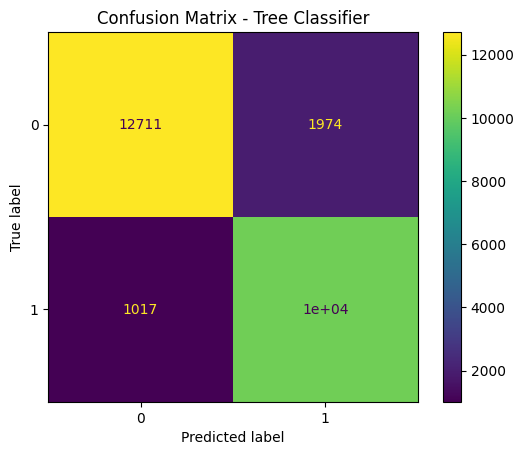

              precision    recall  f1-score   support

           0       0.93      0.87      0.89     14685
           1       0.84      0.91      0.87     11213

    accuracy                           0.88     25898
   macro avg       0.88      0.89      0.88     25898
weighted avg       0.89      0.88      0.88     25898



In [186]:
y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.title('Confusion Matrix - Tree Classifier')
plt.show()

print(classification_report(y_test, y_pred))

### **2.2. Decision Tree Visualization**

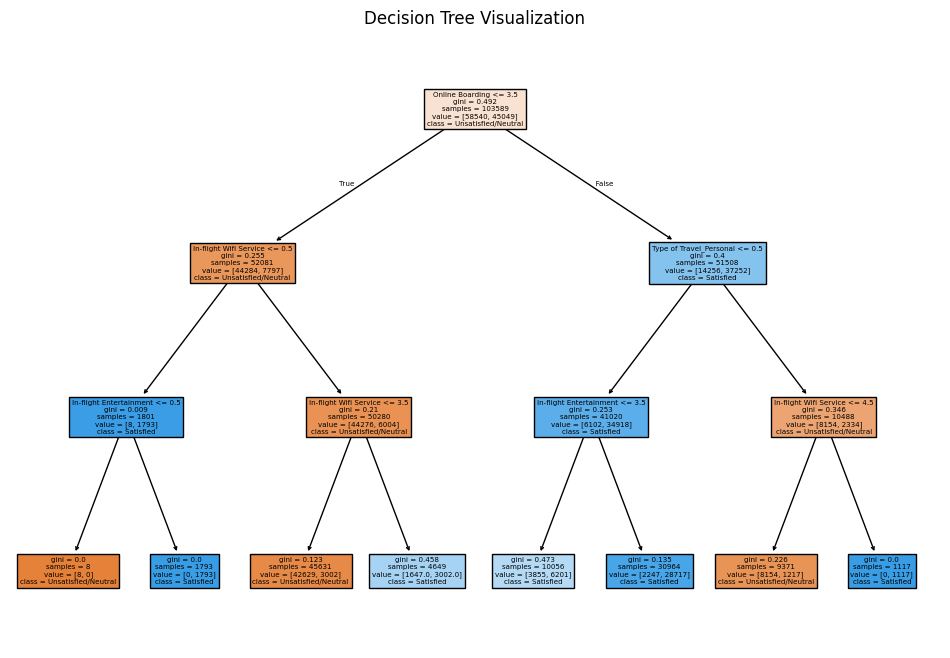

In [187]:
plt.figure(figsize=(12, 8))
plot_tree(tree_clf, feature_names=tree_processed_df.columns, class_names=['Unsatisfied/Neutral', 'Satisfied'], filled=True)
plt.title("Decision Tree Visualization")
plt.show()

### **2.3. Feature importance**

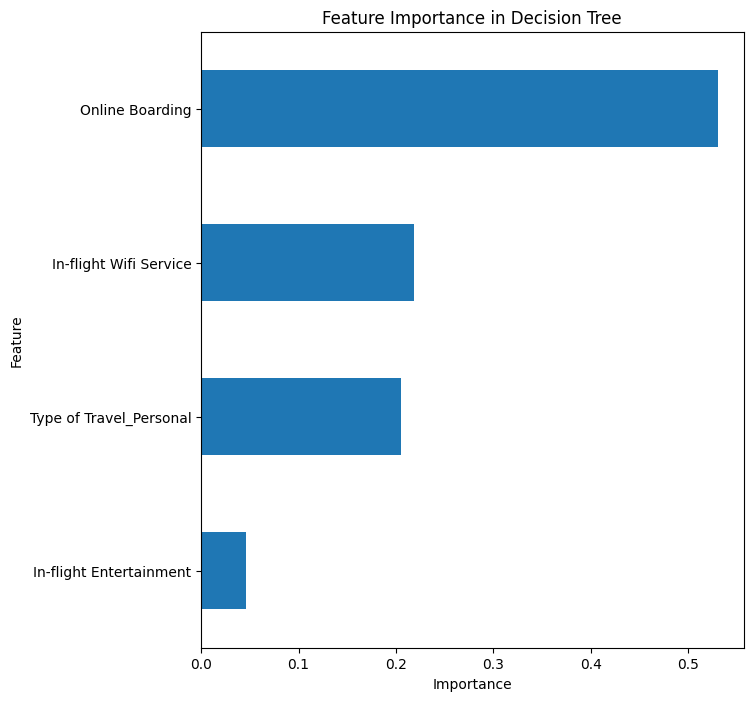

In [188]:
importances = pd.Series(tree_clf.feature_importances_, index=tree_processed_df.columns)
importances = importances[importances > 0]
importances = importances.sort_values() 
importances.plot(kind='barh',figsize=(7,8))
plt.title("Feature Importance in Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

---

## **Task 3. Post-Modeling Explanations**

### **Black box model - XGBoost**

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgboost_classifier = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

xgboost_pipeline = Pipeline(steps=[
    ('preprocessor', tree_preprocessor),
    ('store_df', store_processed_df),
    ('classifier', xgboost_classifier)
])

xgboost_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Gender', 'Customer Type',
                                                   'Type of Travel', 'Class']),
                                                 ('num',
                                                  Pipeline(steps=[('remove_corr',
                                                                   RemoveHighlyCorrelated())]),
                                                  ['Age', 'Flight Distance',
                                                   'Departure Delay',
                                                   'Arrival Delay',
                                                   'Departure and Arrival Time '
                                                   'Convenience',
                                                   'Ease of Online Boo...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

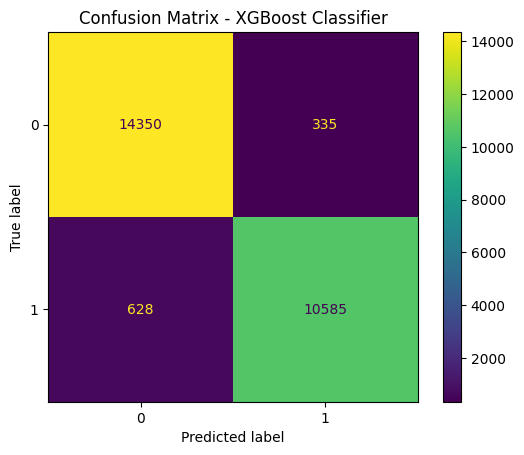

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     14685
           1       0.97      0.94      0.96     11213

    accuracy                           0.96     25898
   macro avg       0.96      0.96      0.96     25898
weighted avg       0.96      0.96      0.96     25898

Accuracy Score: 0.9628156614410379


In [190]:
y_pred = xgboost_pipeline.predict(X_test)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
disp.plot()
plt.title('Confusion Matrix - XGBoost Classifier')
plt.show()

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

### **Fine tuning model**

In [191]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__eval_metric': ['logloss', 'error', 'auc']
}

grid_search = GridSearchCV(
    estimator=xgboost_pipeline,
    param_grid=param_grid,
    cv=5, 
    scoring='accuracy',  
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Best hyperparameters: {grid_search.best_params_}")

best_model = grid_search.best_estimator_

test_accuracy = best_model.score(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best hyperparameters: {'classifier__colsample_bytree': 0.8, 'classifier__eval_metric': 'logloss', 'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
Test accuracy: 0.9644374082940768


## Simplification-based XAI techniques
### Surrogate Model

In [192]:

black_box_pipeline = best_model

# Define the pipeline with preprocessor and XGBoost classifier
surrogate_model = DecisionTreeClassifier(max_depth=3, random_state=42)
surrogate_pipeline = Pipeline(steps=[
    ('preprocessor', tree_preprocessor),
    ('classifier', surrogate_model),
])

y_train_surrogate = black_box_pipeline.predict(X_train)

surrogate_pipeline.fit(X_train, y_train_surrogate)

y_pred_surrogate = surrogate_pipeline.predict(X_test)

print("Agreement Rate (Accuracy):", accuracy_score(y_true=y_pred, y_pred=y_pred_surrogate))
print("Confusion Matrix:\n", confusion_matrix(y_true=y_pred, y_pred=y_pred_surrogate))
print("Classification Report:\n", classification_report(y_true=y_pred, y_pred=y_pred_surrogate))

print("Accuracy in the data (not the black box model predictions): ", accuracy_score(y_true=y_test, y_pred=y_pred_surrogate))

Agreement Rate (Accuracy): 0.8960537493242722
Confusion Matrix:
 [[13007  1971]
 [  721 10199]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91     14978
           1       0.84      0.93      0.88     10920

    accuracy                           0.90     25898
   macro avg       0.89      0.90      0.89     25898
weighted avg       0.90      0.90      0.90     25898

Accuracy in the data (not the black box model predictions):  0.884508456251448


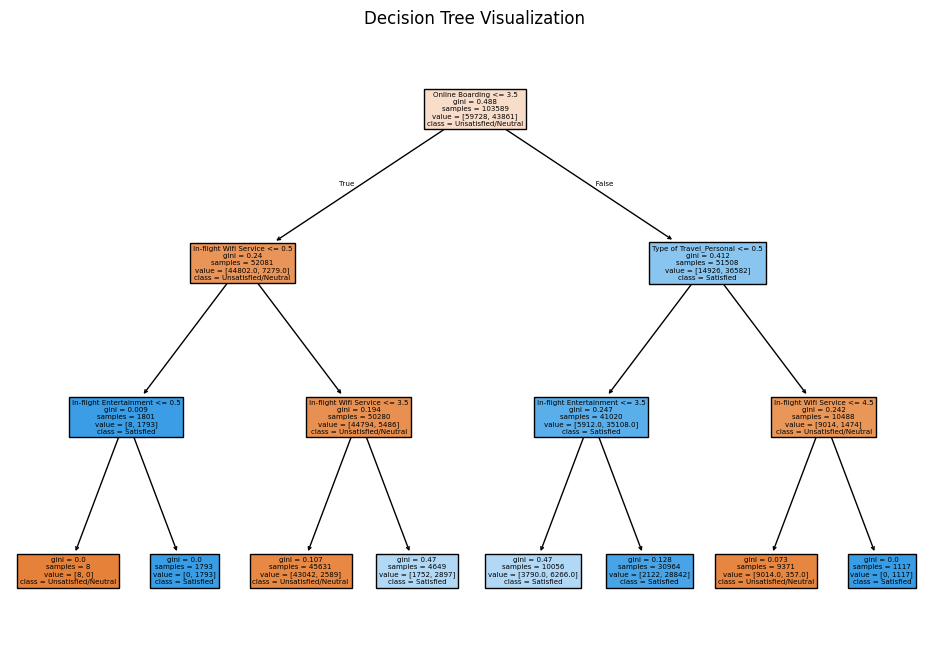

In [193]:
plt.figure(figsize=(12, 8))
plot_tree(surrogate_model, feature_names=tree_processed_df.columns, class_names=['Unsatisfied/Neutral', 'Satisfied'], filled=True)
plt.title("Decision Tree Visualization")
plt.show()

In [194]:
from sklearn.tree import export_text

print("Surrogate Model Rules:\n")
print(export_text(surrogate_model, feature_names=tree_processed_df.columns))

Surrogate Model Rules:

|--- Online Boarding <= 3.50
|   |--- In-flight Wifi Service <= 0.50
|   |   |--- In-flight Entertainment <= 0.50
|   |   |   |--- class: 0
|   |   |--- In-flight Entertainment >  0.50
|   |   |   |--- class: 1
|   |--- In-flight Wifi Service >  0.50
|   |   |--- In-flight Wifi Service <= 3.50
|   |   |   |--- class: 0
|   |   |--- In-flight Wifi Service >  3.50
|   |   |   |--- class: 1
|--- Online Boarding >  3.50
|   |--- Type of Travel_Personal <= 0.50
|   |   |--- In-flight Entertainment <= 3.50
|   |   |   |--- class: 1
|   |   |--- In-flight Entertainment >  3.50
|   |   |   |--- class: 1
|   |--- Type of Travel_Personal >  0.50
|   |   |--- In-flight Wifi Service <= 4.50
|   |   |   |--- class: 0
|   |   |--- In-flight Wifi Service >  4.50
|   |   |   |--- class: 1



## Feature based post-hoc techniques

### SHAP - Global explanation

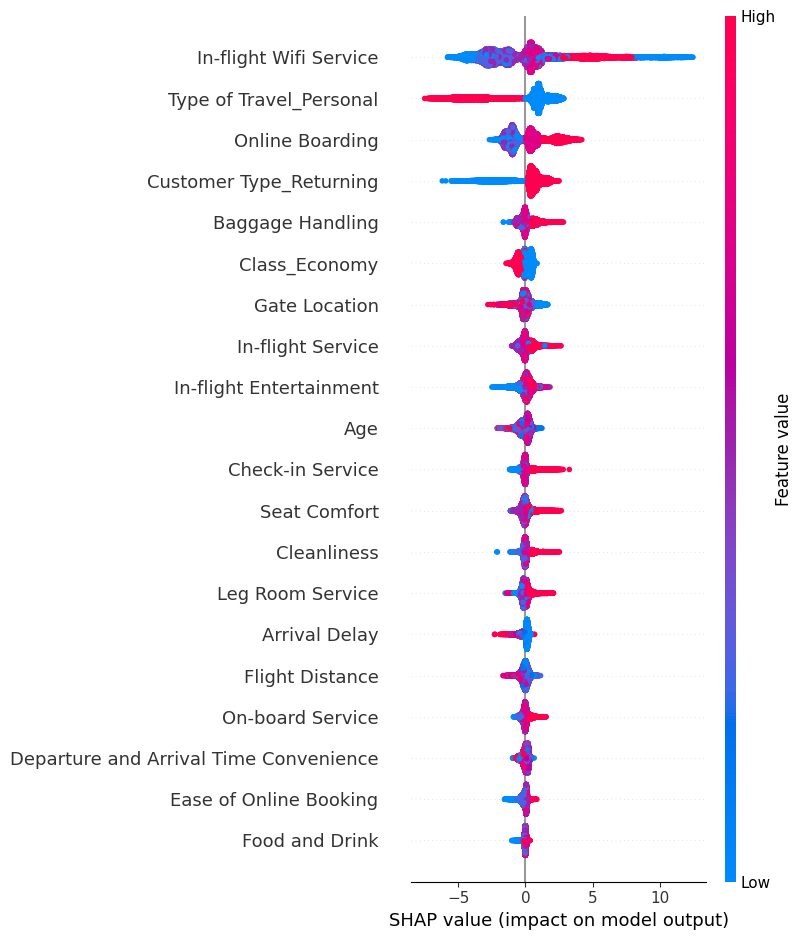

In [195]:
import shap

# get tree processed X
processed_X = store_processed_df.get_processed_df(tree_preprocessor)

# Initialize SHAP explainer
explainer = shap.TreeExplainer(xgboost_classifier)

# Calculate SHAP values
shap_values = explainer.shap_values(processed_X)

# Visualize
shap.summary_plot(shap_values, processed_X, feature_names=processed_X.columns)


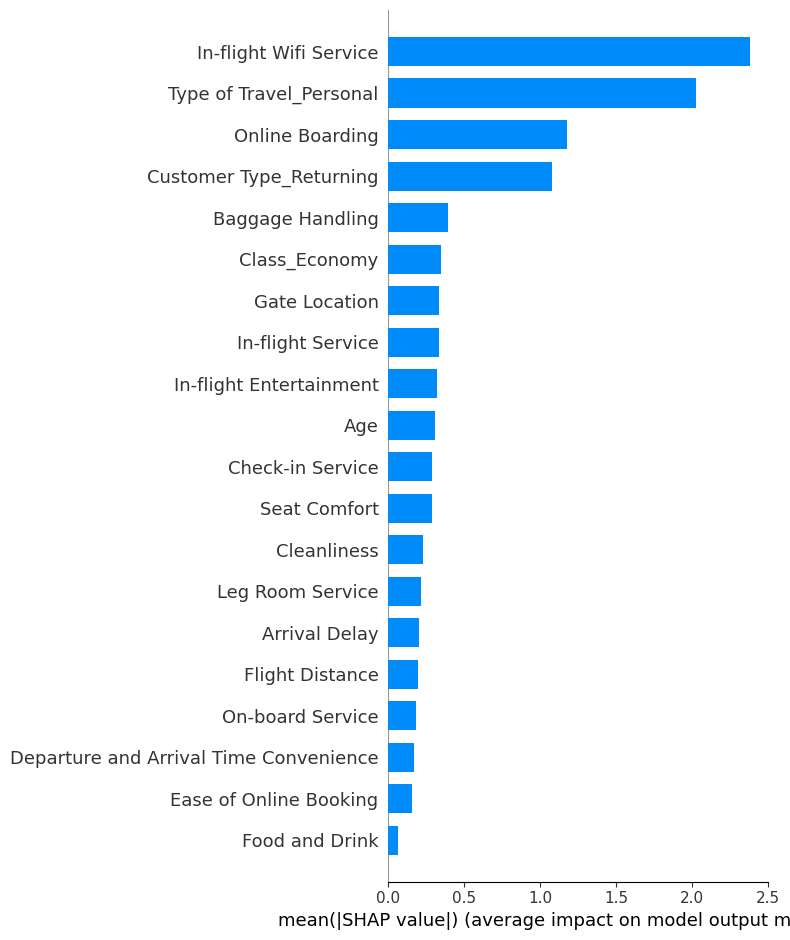

In [196]:
plt.figure(figsize=(12, 8))  # Width = 12, Height = 8
shap.summary_plot(shap_values, processed_X, plot_type="bar")

### SHAP - Local Explanation

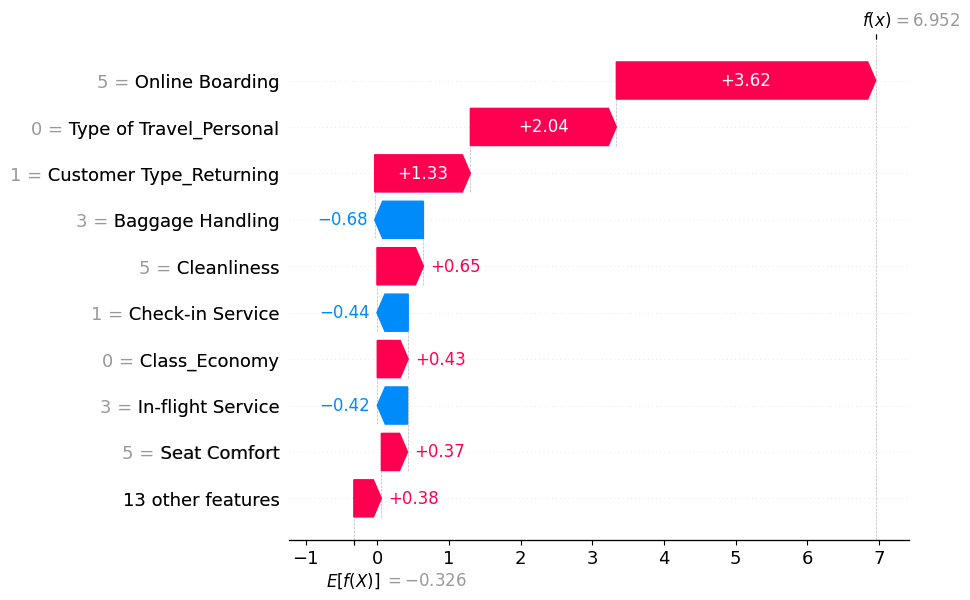

In [197]:
# Select a specific instance
instance_idx = 20
instance = processed_X.iloc[instance_idx]

# Extract the SHAP values for the selected instance
shap_values_instance = shap_values[instance_idx]

# Extract the base value (model's expected value)
base_value = explainer.expected_value

# Create a waterfall plot
shap.waterfall_plot(
    shap.Explanation(values=shap_values_instance, 
                     base_values=base_value, 
                     data=instance,
                     feature_names=processed_X.columns)
)

### Permutation Feature Importance

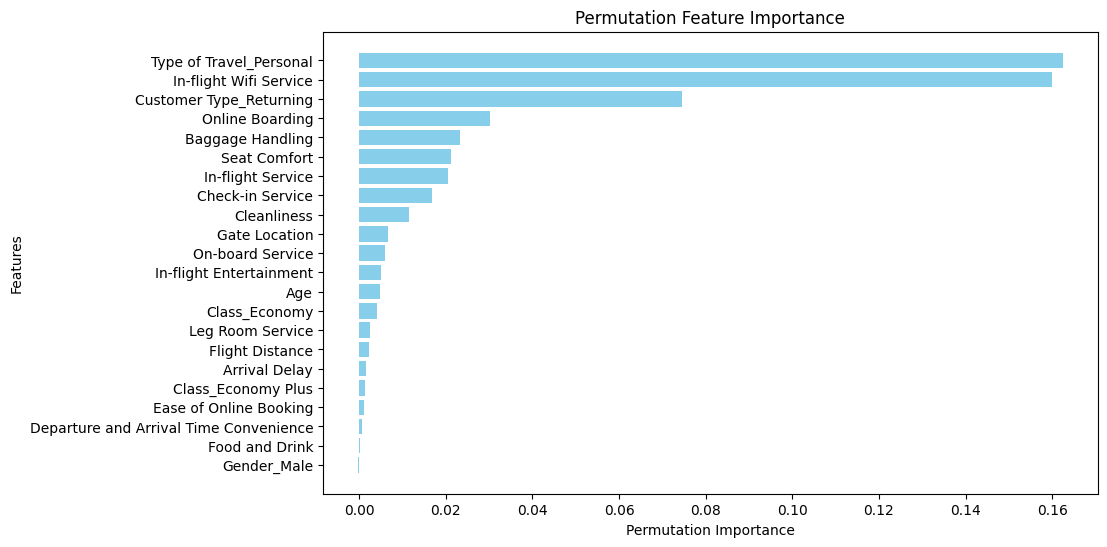

In [198]:
from sklearn.inspection import permutation_importance

X_test_processed = store_processed_df.get_processed_df(tree_preprocessor)

# Compute permutation importance
result = permutation_importance(
    xgboost_classifier, X_test_processed, y_test, scoring="accuracy", n_repeats=10, random_state=42
)

# Create a DataFrame for better visualization
importances = pd.DataFrame({
    'Feature': X_test_processed.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

# Plot results
plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'], importances['Importance'], color='skyblue')
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.show()


## Example-based XAI Techniques
### Anchors

In [199]:
from alibi.explainers import AnchorTabular

# Pre-transform the data to facilitate using Anchors
processed_X_train = tree_preprocessor.transform(X_train)
processed_X_test = tree_preprocessor.transform(X_test)

processed_feature_names = processed_X.columns.to_list()

def predict_fn(x):
    return black_box_pipeline.named_steps["classifier"].predict(x)

# Test if the predict function works
print('Train accuracy: ', accuracy_score(y_train, predict_fn(processed_X_train)))
print('Test accuracy: ', accuracy_score(y_test, predict_fn(processed_X_test)))

print(processed_feature_names)
anchor_explainer = AnchorTabular(predict_fn, feature_names=processed_feature_names)

Train accuracy:  0.9748235816544227
Test accuracy:  0.9644374082940768
['Gender_Male', 'Customer Type_Returning', 'Type of Travel_Personal', 'Class_Economy', 'Class_Economy Plus', 'Age', 'Flight Distance', 'Arrival Delay', 'Departure and Arrival Time Convenience', 'Ease of Online Booking', 'Check-in Service', 'Online Boarding', 'Gate Location', 'On-board Service', 'Seat Comfort', 'Leg Room Service', 'Cleanliness', 'Food and Drink', 'In-flight Service', 'In-flight Wifi Service', 'In-flight Entertainment', 'Baggage Handling']


In [200]:
anchor_explainer.fit(processed_X_train, disc_perc=[25, 50, 75])

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': None, 'disc_perc': [25, 50, 75]},
  'version': '0.9.6'}
)

In [201]:
def show_anchor(anchor_explanation):
    print(f"Anchor:\n{" AND \n".join(anchor_explanation.anchor)}\n")
    print(f"Precision: {anchor_explanation.precision}")
    print(f"Coverage: {anchor_explanation.coverage:.3f}")

In [202]:
idx = 0
y_pred = predict_fn(processed_X_test)
processed_X_test_sat = processed_X_test[(y_test == 1) & (y_pred == 1)]
processed_X_test_unsat = processed_X_test[(y_test == 0) & (y_pred == 0)]
precision_threshold = 0.95

print(f"Well predicted Satisfied instances: {len(processed_X_test_sat)}")
print(f"Well predicted Unsatisfied instances: {len(processed_X_test_unsat)}")
print(f"Misclassified cases: {len(processed_X_test) - len(processed_X_test_sat) - len(processed_X_test_unsat)}")

Well predicted Satisfied instances: 10580
Well predicted Unsatisfied instances: 14397
Misclassified cases: 921


For the same exact instance and parameters, different runs lead to different rules and performance measures, due to the stochastic nature of the approach.


Additionally, in the following cells, we show how the default value `beam_size = 1` leads to worse rules in coverage. Allowing the algorithm to explore more approaches `beam_width = 5` allows it to consistently get better rules (better coverage results), at the cost of more computing time.

The first two anchors shown are for **Unsatisfied/Neutral cases**.

In [203]:
anchor_explanation = anchor_explainer.explain(processed_X_test_unsat[idx], threshold=precision_threshold, beam_size=1)
show_anchor(anchor_explanation)

Anchor:
In-flight Wifi Service <= 3.00 AND 
In-flight Entertainment <= 2.00 AND 
Online Boarding <= 3.00 AND 
Age > 51.00

Precision: 0.9531772575250836
Coverage: 0.035


In [ ]:
anchor_explanation = anchor_explainer.explain(processed_X_test_unsat[idx], threshold=precision_threshold, beam_size=5)
show_anchor(anchor_explanation)

Anchor:
Baggage Handling <= 4.00 AND 
Online Boarding <= 3.00 AND 
In-flight Wifi Service <= 3.00 AND 
On-board Service <= 4.00

Precision: 0.955637707948244
Coverage: 0.335


This next explanation regards an instance that is labeled as **Satisfied**.

In [205]:
anchor_explanation = anchor_explainer.explain(processed_X_test_sat[idx], threshold=precision_threshold, beam_size=5)
show_anchor(anchor_explanation)

Anchor:
In-flight Service > 3.00 AND 
On-board Service > 4.00 AND 
Baggage Handling > 4.00 AND 
Departure and Arrival Time Convenience <= 3.00 AND 
Type of Travel_Personal <= 1.00 AND 
Online Boarding > 2.00 AND 
Gate Location <= 3.00 AND 
Flight Distance > 414.00 AND 
Leg Room Service > 2.00

Precision: 0.952054794520548
Coverage: 0.050


### Dice

In [206]:
import dice_ml
from dice_ml.utils import helpers  # helper functions

ModuleNotFoundError: No module named 'dice_ml'

In [ ]:
d = dice_ml.Data(
    dataframe=df,
    continuous_features=["Age", "Flight Distance", "Departure Delay", "Arrival Delay"],
    outcome_name="Satisfaction",
)
m = dice_ml.Model(model=model_pipeline, backend="sklearn")

satisfied = X_train[y_train == 1]
unsatisfied = X_train[y_train == 0]

In [ ]:
features_to_vary = X.columns.drop(["Gender", "Age"]).to_list()
features_to_vary

['Customer Type',
 'Type of Travel',
 'Class',
 'Flight Distance',
 'Departure Delay',
 'Arrival Delay',
 'Departure and Arrival Time Convenience',
 'Ease of Online Booking',
 'Check-in Service',
 'Online Boarding',
 'Gate Location',
 'On-board Service',
 'Seat Comfort',
 'Leg Room Service',
 'Cleanliness',
 'Food and Drink',
 'In-flight Service',
 'In-flight Wifi Service',
 'In-flight Entertainment',
 'Baggage Handling']

In [ ]:
query_instances = [satisfied.iloc[[0]]] + [unsatisfied.iloc[[0]]]

In [ ]:
def show_counterfactuals(exp):
    dice_exp = exp.generate_counterfactuals(
        query_instances,
        total_CFs=5,
        desired_class="opposite",
        verbose=False,
        features_to_vary=features_to_vary,
    )
    return dice_exp.visualize_as_dataframe(show_only_changes=True)

In [ ]:
exp_random = dice_ml.Dice(d, m, method="random")
show_counterfactuals(exp_random)

100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


Query instance (original outcome : 1)


,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,Male,37,Returning,Business,Business,2060,0,0.0,5,5,...,5,4,5,3,2,5,5,5,5,1



Diverse Counterfactual set (new outcome: 0)


,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,-,-,-,-,-,-,-,-,-,0,...,-,-,-,-,-,-,1,-,2,0
1,-,-,First-time,-,-,-,-,-,-,-,...,-,-,-,-,0,-,2,-,-,0
2,-,-,First-time,-,-,-,-,-,-,-,...,-,-,-,-,-,-,1,-,-,0
3,-,-,-,Personal,-,-,-,-,-,-,...,-,-,-,-,-,-,4,-,-,0
4,-,-,First-time,-,-,-,-,-,-,-,...,2,-,-,-,-,-,4,-,-,0


Query instance (original outcome : 0)


,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,Male,38,Returning,Business,Business,564,0,0.0,2,2,...,1,4,1,4,5,1,1,1,1,0



Diverse Counterfactual set (new outcome: 1)


,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,5,-,-,-,-,-,1
1,-,-,-,-,-,-,-,-,-,-,...,-,5,-,-,-,-,-,-,4,1
2,-,-,-,-,-,-,-,-,-,-,...,5,-,-,5,-,-,-,-,-,1
3,-,-,-,-,-,-,-,-,-,-,...,-,-,-,0,-,-,5,-,-,1
4,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,5,-,-,1


In [ ]:
exp_genetic = dice_ml.Dice(d, m, method='genetic')
show_counterfactuals(exp_genetic)

100%|██████████| 2/2 [00:05<00:00,  2.82s/it]

Query instance (original outcome : 1)


,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,Male,37,Returning,Business,Business,2060,0,0.0,5,5,...,5,4,5,3,2,5,5,5,5,1



Diverse Counterfactual set (new outcome: 0)


,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,-,-,-,-,-,-,-,-,2,2,...,-,-,4,1,5,-,-,-,-,0
0,-,-,-,Personal,-,-,-,-,-,3,...,-,1,-,1,1,1,3,1,-,0
0,-,-,First-time,-,-,-,-,-,-,-,...,-,-,-,1,4,3,1,3,3,0
0,-,-,-,-,-,-,-,-,0,0,...,-,2,0,-,1,-,1,-,-,0
0,-,-,First-time,-,Economy,-,-,-,-,-,...,4,5,-,-,-,2,1,3,3,0


Query instance (original outcome : 0)


,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,Male,38,Returning,Business,Business,564,0,0.0,2,2,...,1,4,1,4,5,1,1,1,1,0



Diverse Counterfactual set (new outcome: 1)


,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,-,-,-,-,-,31,-,-,4,-,...,-,-,-,-,2,4,5,5,-,1
0,-,-,-,-,-,-,-,-,1,1,...,-,-,3,-,4,-,-,4,4,1
0,-,-,-,-,-,-,-,-,-,-,...,5,-,4,-,4,5,2,4,5,1
0,-,-,-,-,-,31,-,-,3,-,...,2,3,4,3,4,4,4,-,-,1
0,-,-,-,-,-,-,-,-,-,4,...,-,-,3,3,3,-,-,4,4,1


In [ ]:
exp_KD = dice_ml.Dice(d, m, method='kdtree')
show_counterfactuals(exp_KD)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:04<00:00,  2.26s/it]

Query instance (original outcome : 1)


,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,Male,37,Returning,Business,Business,2060,0,0.0,5,5,...,5,4,5,3,2,5,5,5,5,1



No counterfactuals found!
Query instance (original outcome : 0)


,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
0,Male,38,Returning,Business,Business,564,0,0.0,2,2,...,1,4,1,4,5,1,1,1,1,0



Diverse Counterfactual set (new outcome: 1)


,Gender,Age,Customer Type,Type of Travel,Class,Flight Distance,Departure Delay,Arrival Delay,Departure and Arrival Time Convenience,Ease of Online Booking,...,On-board Service,Seat Comfort,Leg Room Service,Cleanliness,Food and Drink,In-flight Service,In-flight Wifi Service,In-flight Entertainment,Baggage Handling,Satisfaction
65897,-,-,-,-,-,-,-,-,3,3,...,4,-,4,5,2,4,3,4,4,1
